# scHopfield: Comprehensive Energy Landscape Analysis Pipeline

This notebook demonstrates the complete analysis capabilities of the scHopfield package for energy landscape analysis of single-cell dynamics. The analysis is organized into the following sections:

## Table of Contents
1. [Setup and Data Loading](#1-setup-and-data-loading)
2. [Data Preprocessing](#2-data-preprocessing) 
3. [Energy Landscape Analysis](#3-energy-landscape-analysis)
4. [Network Analysis](#4-network-analysis)
5. [Trajectory Simulation](#5-trajectory-simulation)
6. [Advanced Jacobian Analysis](#6-advanced-jacobian-analysis)
7. [Network Centrality Analysis](#7-network-centrality-analysis)
8. [Energy Landscape Dynamics](#8-energy-landscape-dynamics)
9. [Results Summary](#9-results-summary)

## 1. Setup and Data Loading

In [1]:
# Import required libraries
import anndata
import celloracle as co
import dynamo as dyn
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy as scp
from scipy.spatial.distance import squareform
from scHopfield.analysis import LandscapeAnalyzer, NetworkAnalyzer
from scHopfield.utils.analysis_utilities import (
    change_spines, extract_cluster_colors, prepare_scaffold_matrix, get_correlation_table
)
import seaborn as sns
import sys
from tqdm import tqdm

In [2]:
%matplotlib inline

In [3]:
# Configuration and dataset selection
config_path = '/home/bernaljp/KAUST'
sys.path.append(config_path)
import config

name = 'Hematopoiesis'

In [4]:
# Load dataset
dataset = config.datasets[name]
cluster_key = config.cluster_keys[name]
velocity_key = config.velocity_keys[name]
spliced_key = config.spliced_keys[name]
title = config.titles[name]
order = config.orders[name]
dynamic_genes_key = config.dynamic_genes_keys[name]
degradation_key = config.degradation_keys[name]

adata = dyn.read_h5ad(config.data_path+dataset) if dataset.split('.')[1]=='h5ad' else dyn.read_loom(config.data_path+dataset)
adata

AnnData object with n_obs × n_vars = 1947 × 1956
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori'
    var: 'gene_name', 'gene_id', 'nCells', 'nCounts', 'pass_basic

## 2. Data Preprocessing

In [5]:
# Dataset-specific preprocessing
if name=='Hematopoiesis':
    bad_genes = np.unique(np.where(np.isnan(adata.layers[velocity_key].toarray()))[1])
    adata = adata[:,~np.isin(range(adata.n_vars),bad_genes)]
elif name=='Endocrinogenesis_preprocessed':
    pass
else:
    pp = dyn.preprocessing.Preprocessor()
    pp.preprocess_adata(adata, recipe='monocle')
    dyn.tl.dynamics(adata,cores=-1)
    dyn.tl.reduceDimension(adata,cores=-1)
    dyn.tl.cell_velocities(adata)
    dyn.tl.cell_wise_confidence(adata)
    if 'vel_params_names' in adata.uns:
        gamma_idx = adata.uns['vel_params_names'].index('gamma')
        adata.var['gamma'] = adata.varm['vel_params'][:,gamma_idx]

|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_type by stack threshold when stacking color because it is not a numeric type


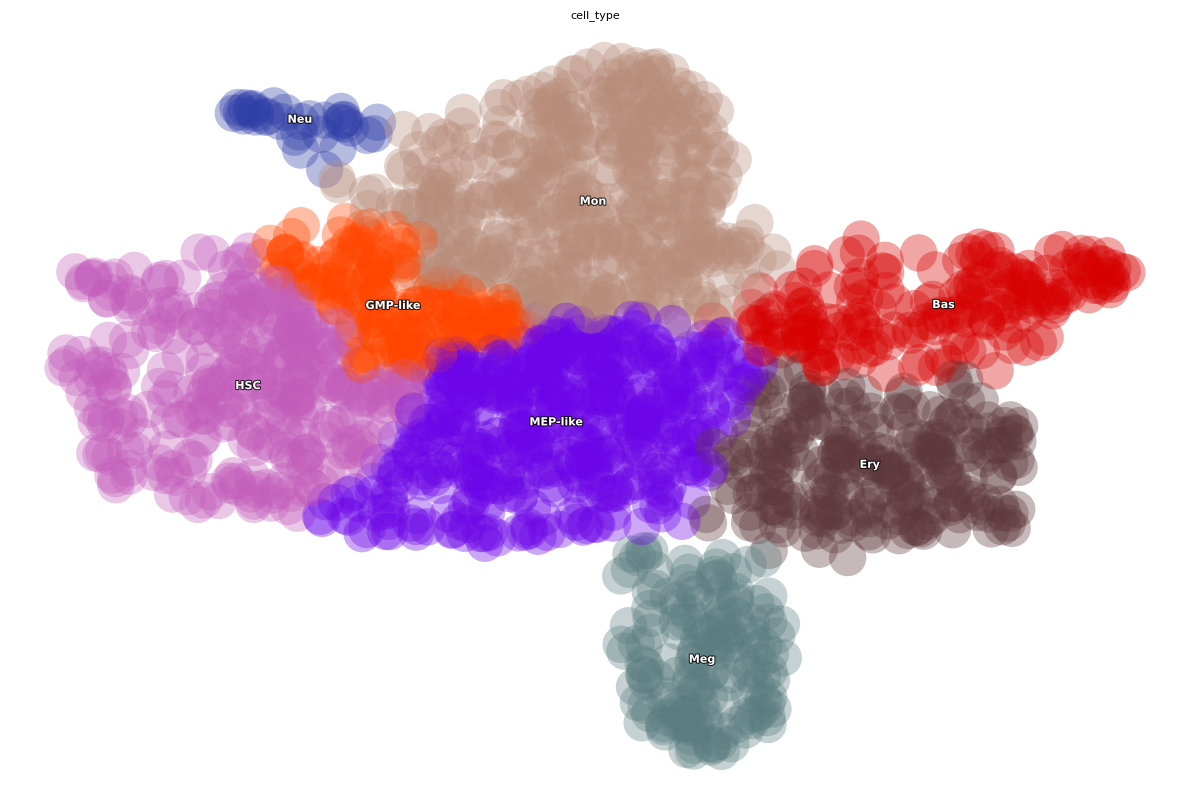

|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_type by stack threshold when stacking color because it is not a numeric type


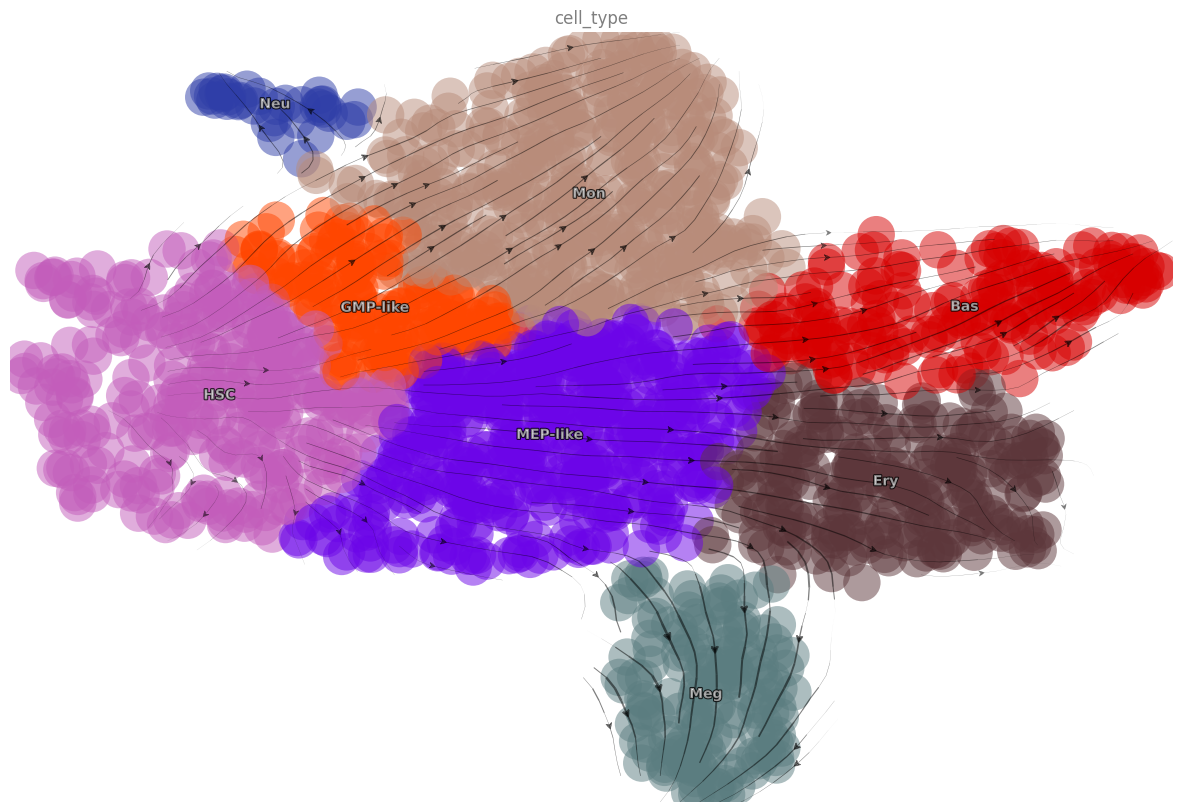

In [6]:
# Basic visualization
dyn.pl.scatters(adata, color=cluster_key, basis="umap", show_legend="on data", figsize=(15,10), save_show_or_return='return', pointsize=2, alpha=0.35)
plt.show()

ax = dyn.pl.streamline_plot(adata, color=cluster_key, basis="umap", show_legend="on data", show_arrowed_spines=False, 
                            figsize=(15,10), save_show_or_return='return', pointsize=2, alpha=0.35)
change_spines(ax)
plt.show()

In [7]:
# Extract colors for visualization
colors = extract_cluster_colors(adata, cluster_key)
print(f"Extracted colors for {len(colors)} clusters: {list(colors.keys())}")

Extracted colors for 8 clusters: ['Mon', 'Meg', 'MEP-like', 'Ery', 'Bas', 'GMP-like', 'HSC', 'Neu']


In [8]:
# Load and prepare scaffold matrix
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
base_GRN.drop(['peak_id'], axis=1, inplace=True)

scaffold = prepare_scaffold_matrix(adata, base_GRN)
print(f"Prepared scaffold matrix: {scaffold.shape}")
print(f"Non-zero elements: {(scaffold != 0).sum().sum()} / {scaffold.size}")

TFs in scaffold: 73
Target genes in scaffold: 1148
Prepared scaffold matrix: (1728, 1728)
Non-zero elements: 19384 / 2985984


## 3. Energy Landscape Analysis

In [9]:
# Initialize LandscapeAnalyzer
ls = LandscapeAnalyzer(adata, 
               spliced_matrix_key=spliced_key, 
               velocity_key=velocity_key, 
               genes=adata.var['use_for_dynamics'].values, 
               cluster_key=cluster_key, 
               w_threshold=1e-12,
               w_scaffold=scaffold.values, 
               scaffold_regularization=1e-2,
               only_TFs=True,
               criterion='MSE',
               batch_size=128,
               n_epochs=1000,
               refit_gamma=False,
               skip_all=False,
               device='cpu')

/home/bernaljp/KAUST/scHopfield/utils/utilities.py:81: RuntimeWarning: divide by zero encountered in divide
  ty = np.log(y / (1 - y))
/home/bernaljp/KAUST/scHopfield/utils/utilities.py:81: RuntimeWarning: divide by zero encountered in log
  ty = np.log(y / (1 - y))


AttributeError: 'LandscapeAnalyzer' object has no attribute 'fit_interactions'

In [ ]:
# Compute energies
ls.write_energies()

# Energy summary statistics
summary_stats = ls.adata.obs[[cluster_key,'Total_energy','Interaction_energy','Degradation_energy','Bias_energy']].groupby(cluster_key).describe()
for energy in summary_stats.columns.levels[0]:
    summary_stats[(energy,'cv')] = summary_stats[(energy,'std')]/summary_stats[(energy,'mean')]

summary_stats['Total_energy']

In [ ]:
# Energy visualization
from scHopfield.visualization import EnergyPlotter
energy_plotter = EnergyPlotter(ls)

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[colors[i] for i in order])
energy_plotter.plot_energy_boxplots(figsize=(22,11), order=order, colors=colors)
energy_plotter.plot_energy_scatters(figsize=(15,15), order=order)
plt.legend(loc='upper left', bbox_to_anchor=(-0.2, 1.2))
plt.show()

# Violin plots for energy distributions
energy_plotter.plot_energy_violin_plots(ls.E, order=order, figsize=(15, 6))
plt.title('Total Energy Distribution')
plt.show()

In [ ]:
# Energy-gene correlations
ls.energy_genes_correlation()

# Top correlated genes table
correlation_table = get_correlation_table(ls, n_top_genes=10, which_correlation='total')
correlation_table

In [ ]:
# Correlation visualization
from scHopfield.visualization import EnergyCorrelationPlotter
corr_plotter = EnergyCorrelationPlotter(ls)

corr_plotter.plot_correlations_grid(colors=colors, order=order, energy='total', figsize=(15, 15))
ls.plot_high_correlation_genes(top_n=10, energy='total', cluster='all', absolute=False, basis='umap', figsize=(15, 10))

## 4. Network Analysis

In [ ]:
# Cell-type correlations
ls.celltype_correlation()

# Dendrogram visualization
plt.figure(figsize=(9, 3))
Z = scp.cluster.hierarchy.linkage(squareform(1-ls.cells_correlation), 'complete', )
fig,axs = plt.subplots(1,1,figsize=(10, 4), tight_layout=True)
scp.cluster.hierarchy.dendrogram(Z, labels = ls.cells_correlation.index, ax=axs)
axs.get_yaxis().set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.set_title('Celltype RV score')
plt.show()

In [ ]:
# Network correlations
ls.network_correlations()

# Network correlation visualization
metrics = ['jaccard', 'hamming', 'euclidean', 'pearson', 'pearson_bin', 'mean_col_corr', 'singular']
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    if hasattr(ls, metric):
        matrix = getattr(ls, metric)
        sns.heatmap(matrix, annot=True, fmt='.3f', ax=axes[i], cmap='viridis')
        axes[i].set_title(f'{metric.capitalize()} Distance/Correlation')

axes[-1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Interaction matrix visualization
from scHopfield.visualization import NetworkPlotter
network_plotter = NetworkPlotter(ls)

fig, axes = plt.subplots(2, len(order)//2 + len(order)%2, figsize=(6*len(order), 12))
axes = axes.flatten() if len(order) > 1 else [axes]

for i, cluster in enumerate(order):
    if i < len(axes):
        network_plotter.plot_interaction_matrix(cluster=cluster, ax=axes[i])

plt.tight_layout()
plt.show()

## 5. Trajectory Simulation

In [ ]:
# Cell trajectory simulation
from scHopfield.simulation import DynamicsSimulator

dynamics_sim = DynamicsSimulator(ls)
time_points = np.linspace(0, 20, 200)

# Simulate trajectories for each cluster
trajectories = {}
for cluster in order:
    cluster_mask = ls.adata.obs[cluster_key] == cluster
    cell_indices = np.where(cluster_mask)[0]
    random_cell_idx = np.random.choice(cell_indices)
    initial_state = ls.get_matrix(spliced_key)[random_cell_idx, ls.genes]
    
    trajectory = dynamics_sim.simulate(
        initial_state=initial_state,
        time_points=time_points,
        cluster=cluster
    )
    trajectories[cluster] = trajectory

print(f"Simulated trajectories for {len(trajectories)} clusters")

In [ ]:
# Trajectory visualization
from scHopfield.visualization import TrajectoryPlotter
trajectory_plotter = TrajectoryPlotter(ls)

fig, axes = plt.subplots(len(order), 2, figsize=(15, 5*len(order)))
if len(order) == 1:
    axes = axes.reshape(1, -1)

for i, cluster in enumerate(order):
    # Plot gene dynamics
    trajectory_plotter.plot_gene_dynamics(
        trajectory=trajectories[cluster].T,
        time_points=time_points,
        gene_indices=list(range(min(5, len(ls.genes)))),
        ax=axes[i, 0]
    )
    axes[i, 0].set_title(f'{cluster} - Gene Dynamics')
    
    # Plot phase portrait
    trajectory_plotter.plot_phase_portrait(
        gene_indices=(0, 1),
        cluster=cluster,
        resolution=20,
        ax=axes[i, 1]
    )
    axes[i, 1].set_title(f'{cluster} - Phase Portrait')

plt.tight_layout()
plt.show()

In [ ]:
# Energy evolution analysis
from scHopfield.simulation import EnergySimulator

energy_sim = EnergySimulator(ls)

# Compute energy evolution for each cluster
energy_evolutions = {}
for cluster in order:
    cluster_mask = ls.adata.obs[cluster_key] == cluster
    cell_indices = np.where(cluster_mask)[0]
    random_cell_idx = np.random.choice(cell_indices)
    initial_state = ls.get_matrix(spliced_key)[random_cell_idx, ls.genes]
    
    energy_results = energy_sim.simulate_with_energy(
        initial_state=initial_state,
        time_points=time_points,
        cluster=cluster
    )
    energy_evolutions[cluster] = energy_results

# Plot energy evolution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

energy_types = ['total_energy', 'interaction_energy', 'degradation_energy', 'bias_energy']
titles = ['Total Energy', 'Interaction Energy', 'Degradation Energy', 'Bias Energy']

for i, (energy_type, title) in enumerate(zip(energy_types, titles)):
    for cluster in order:
        axes[i].plot(time_points, energy_evolutions[cluster][energy_type], 
                    label=cluster, linewidth=2)
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Energy')
    axes[i].set_title(title)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Energy Evolution Along Trajectories', fontsize=16)
plt.tight_layout()
plt.show()

## 6. Advanced Jacobian Analysis

In [ ]:
# Jacobian computation and eigenvalue analysis
from scHopfield.analysis import JacobianAnalyzer

jacobian_analyzer = JacobianAnalyzer(ls)
jacobian_analyzer.compute_jacobians()

print("Jacobian analysis completed")
print(f"Computed Jacobians for {ls.adata.n_obs} cells")
print(f"Jacobian shape: {jacobian_analyzer.jacobians.shape}")
print(f"Eigenvalues shape: {jacobian_analyzer.eigenvalues.shape}")

In [ ]:
# Eigenvalue visualization
from scHopfield.visualization import JacobianPlotter

jacobian_plotter = JacobianPlotter(ls)
ls.adata.layers['jacobian_eigenvalues'] = jacobian_analyzer.eigenvalues

jacobian_plotter.plot_jacobian_summary(fig_size=(20, 5), part='real', show=True)

# Eigenvalue statistics
ls.adata.obs['eval_positive'] = np.sum(np.real(jacobian_analyzer.eigenvalues) > 0, axis=1)
ls.adata.obs['eval_negative'] = np.sum(np.real(jacobian_analyzer.eigenvalues) < 0, axis=1)
ls.adata.obs['eval_mean_real'] = np.mean(np.real(jacobian_analyzer.eigenvalues), axis=1)
ls.adata.obs['jacobian_trace'] = np.trace(jacobian_analyzer.jacobians, axis1=1, axis2=2)

print(f"Mean positive eigenvalues per cell: {ls.adata.obs['eval_positive'].mean():.2f}")
print(f"Mean negative eigenvalues per cell: {ls.adata.obs['eval_negative'].mean():.2f}")

In [ ]:
# Eigenvalue distribution analysis
jacobian_plotter.plot_eigenvalue_distributions(
    jacobian_analyzer.eigenvalues, 
    ls.adata.obs, 
    cluster_key, 
    order, 
    figsize=(15, 10)
)

In [ ]:
# Eigenvector analysis
df_eigenvalues_combined = jacobian_plotter.plot_eigenvector_analysis(
    jacobian_analyzer.jacobians,
    ls.adata.obs,
    cluster_key,
    ls.gene_names,
    order,
    colors,
    n_genes_table=10,
    figsize=(18, 6)
)

df_eigenvalues_combined

## 7. Network Centrality Analysis

In [ ]:
# Network centrality analysis
from scHopfield.analysis import NetworkAnalyzer

network_analyzer = NetworkAnalyzer(ls)
centrality_results = network_analyzer.compute_network_centralities()

print(f"Computed centralities for {len(centrality_results)} clusters")
print(f"Centrality measures: {list(centrality_results[list(centrality_results.keys())[0]].columns[:-1])}")

In [ ]:
# Centrality visualization
network_analyzer.plot_centrality_rankings(
    centrality_results, 
    order, 
    colors, 
    score='eigenvector_centrality',
    n_genes=8,
    figsize=(5*len(order), 6)
)

# Centrality comparison tables
df_eigenvector = network_analyzer.get_centrality_table(
    centrality_results, 
    order, 
    score='eigenvector_centrality', 
    n_genes=10
)

df_eigenvector

In [ ]:
# Network graphs with centrality-based node sizing
network_analyzer.plot_networks_with_centrality(
    ls,
    centrality_results,
    order,
    colors,
    score='eigenvector_centrality',
    threshold=0.01,
    max_nodes=15,
    figsize=(8 * ((len(order) + 1) // 2), 16)
)

In [ ]:
# Expression-centrality correlation analysis
expression_centrality_corr = network_analyzer.analyze_expression_centrality_correlation(
    ls, centrality_results, spliced_key, cluster_key, order
)

network_analyzer.plot_expression_centrality_correlations(
    expression_centrality_corr, order, figsize=(12, 8)
)

## 8. Energy Landscape Dynamics

In [ ]:
# Attractor analysis
from scHopfield.simulation import AttractorAnalyzer

attractor_analyzer = AttractorAnalyzer(ls)

# Find attractors for each cluster
attractor_results = {}
for cluster in order:
    print(f"Finding attractors for {cluster}...")
    attractors = attractor_analyzer.find_attractors(
        cluster=cluster,
        n_initial_conditions=20,
        simulation_time=50.0,
        tolerance=1e-3
    )
    attractor_results[cluster] = attractors
    
    print(f"  Found {len(attractors['fixed_points'])} fixed points")
    print(f"  Found {len(attractors['limit_cycles'])} limit cycles")
    print(f"  Found {len(attractors['other_attractors'])} other attractors")

In [ ]:
# Stability analysis
stability_results = {}
for cluster in order:
    fixed_points = attractor_results[cluster]['fixed_points']
    if len(fixed_points) > 0:
        print(f"\nAnalyzing stability for {cluster} ({len(fixed_points)} fixed points):")
        
        cluster_stability = []
        for i, fp in enumerate(fixed_points):
            stability = attractor_analyzer.analyze_stability(fp, cluster=cluster)
            cluster_stability.append(stability)
            
            eigenvals = stability['eigenvalues']
            stability_type = stability['stability']
            
            print(f"  Fixed point {i+1}: {stability_type}")
            print(f"    Max real eigenvalue: {np.max(np.real(eigenvals)):.4f}")
            
        stability_results[cluster] = cluster_stability
    else:
        print(f"\nNo fixed points found for {cluster}")
        stability_results[cluster] = []

In [ ]:
# Energy minima and barrier analysis
energy_minima = {}
barrier_analysis = {}

for cluster in order[:3]:  # Limit for computational efficiency
    print(f"Analyzing energy landscape for {cluster}...")
    minima = energy_sim.find_energy_minima(cluster=cluster, n_random_starts=20)
    energy_minima[cluster] = minima
    print(f"  Found {len(minima)} energy minima")
    
    # Compute energy barriers
    if len(minima) >= 2:
        state1 = minima[0]['state']
        state2 = minima[1]['state']
        
        barrier_result = energy_sim.compute_energy_barrier(
            state1, state2, cluster=cluster, n_points=30
        )
        barrier_analysis[cluster] = barrier_result
        
        print(f"  Barrier height: {barrier_result['barrier_height']:.4f}")

In [ ]:
# Energy barrier visualization
if barrier_analysis:
    fig, axes = plt.subplots(1, len(barrier_analysis), figsize=(6*len(barrier_analysis), 5))
    if len(barrier_analysis) == 1:
        axes = [axes]
    
    for i, (cluster, barrier_data) in enumerate(barrier_analysis.items()):
        t = np.linspace(0, 1, len(barrier_data['energies']))
        axes[i].plot(t, barrier_data['energies'], 'o-', color=colors[cluster], linewidth=2, markersize=4)
        axes[i].axhline(y=barrier_data['energies'][0], color='green', linestyle='--', alpha=0.7, label='Start')
        axes[i].axhline(y=barrier_data['energies'][-1], color='red', linestyle='--', alpha=0.7, label='End')
        axes[i].axvline(x=barrier_data['barrier_position']/len(barrier_data['energies']), 
                       color='orange', linestyle=':', alpha=0.7, label='Barrier')
        
        axes[i].set_xlabel('Path Progress')
        axes[i].set_ylabel('Energy')
        axes[i].set_title(f'{cluster}\nEnergy Barrier: {barrier_data["barrier_height"]:.3f}')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Landscape visualization
from scHopfield.visualization import LandscapePlotter
landscape_plotter = LandscapePlotter(ls)

# Parameter distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
landscape_plotter.plot_parameter_distribution(parameter='threshold', ax=axes[0])
landscape_plotter.plot_parameter_distribution(parameter='exponent', ax=axes[1])
landscape_plotter.plot_parameter_distribution(parameter='offset', ax=axes[2])
plt.tight_layout()
plt.show()

# Parameter correlations
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
landscape_plotter.plot_parameter_correlation(param1='threshold', param2='exponent', ax=axes[0])
landscape_plotter.plot_parameter_correlation(param1='threshold', param2='offset', ax=axes[1])
landscape_plotter.plot_parameter_correlation(param1='exponent', param2='offset', ax=axes[2])
plt.tight_layout()
plt.show()

# Energy decomposition
fig, axes = plt.subplots(len(order), 1, figsize=(15, 5 * len(order)))
if len(order) == 1:
    axes = [axes]

for i, cluster in enumerate(order):
    landscape_plotter.plot_energy_decomposition(cluster=cluster, n_genes=8, ax=axes[i])

plt.tight_layout()
plt.show()

## 9. Results Summary

In [ ]:
# Comprehensive results summary
final_results = {
    'landscape_analyzer': ls,
    'interaction_matrices': ls.W,
    'bias_vectors': ls.I,
    'fitted_parameters': {
        'threshold': ls.threshold,
        'exponent': ls.exponent,
        'offset': ls.offset
    },
    'energies': {
        'total': ls.E,
        'interaction': ls.E_int,
        'degradation': ls.E_deg,
        'bias': ls.E_bias
    },
    'correlations': {
        'total': ls.correlation,
        'interaction': ls.correlation_interaction,
        'degradation': ls.correlation_degradation,
        'bias': ls.correlation_bias
    },
    'network_correlations': {
        'jaccard': ls.jaccard,
        'hamming': ls.hamming,
        'euclidean': ls.euclidean,
        'pearson': ls.pearson,
        'pearson_bin': ls.pearson_bin,
        'mean_col_corr': ls.mean_col_corr,
        'singular': ls.singular
    },
    'cell_correlations': ls.cells_correlation,
    'jacobian_analysis': {
        'jacobians': jacobian_analyzer.jacobians,
        'eigenvalues': jacobian_analyzer.eigenvalues,
        'eigenvector_analysis': df_eigenvalues_combined
    },
    'attractor_analysis': attractor_results,
    'stability_analysis': stability_results,
    'trajectories': trajectories,
    'energy_evolutions': energy_evolutions,
    'centrality_analysis': {
        'centrality_results': centrality_results,
        'expression_centrality_correlation': expression_centrality_corr
    },
    'energy_landscape': {
        'energy_minima': energy_minima,
        'barrier_analysis': barrier_analysis
    }
}

print("=" * 80)
print("FINAL COMPREHENSIVE ANALYSIS SUMMARY")
print("=" * 80)

print(f"Dataset: {name}")
print(f"Total cells: {ls.adata.n_obs:,}")
print(f"Dynamic genes: {len(ls.genes)}")
print(f"Cell types: {len(order)} ({', '.join(order)})")

print(f"\nCore Analysis:")
print(f"  Interaction matrices: {len(ls.W)}")
print(f"  Energy calculations: {len(ls.E)} clusters")
print(f"  Network correlation metrics: {len(final_results['network_correlations'])}")

print(f"\nAdvanced Analysis:")
print(f"  Jacobian analysis: {jacobian_analyzer.jacobians.shape[0]:,} cells")
print(f"  Attractor analysis: {sum(len(v['fixed_points']) + len(v['limit_cycles']) + len(v['other_attractors']) for v in attractor_results.values())} attractors")
print(f"  Network centrality: {len(centrality_results)} clusters")
print(f"  Energy minima: {len(energy_minima)} clusters")
print(f"  Barrier analysis: {len(barrier_analysis)} barriers")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETED SUCCESSFULLY")
print("=" * 80)